In [237]:

import yfinance as yf
import pandas as pd 
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import scipy.stats as st
#
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [2]:

ticker_cocoa = yf.Ticker("CC=F")
ticker_coffee = yf.Ticker("KC=F")
"""
compare the price of the cocoa & Coffee commodity with the price cacoa based drinks in the coffee dataset
https://www.kaggle.com/datasets/ayeshasiddiqa123/coffee-dataset
ticker = yf.Ticker("CC=F")


null hypothesis (H₀) and an alternative hypothesis (H₁):
H₀: There is no relationship between the price and the cocoa Comodity price.
H₁: There is a significant relationship between price and the cocoa Comodity price.

"""

# Get historical market data
# Download 2 years of historical data (daily)
hist_cocoa = ticker_cocoa.history(period="2y")
hist_coffee = ticker_coffee.history(period="3y")


# prepare stock dataframe
# change granularity frome datetime to date (for joining with other data)
df_ticker_cocoa = hist_cocoa[["Close"]].reset_index()  # reset_index to bring Date back as a column
df_ticker_cocoa["Date"] = pd.to_datetime(df_ticker_cocoa["Date"]).dt.date  # keep only date


df_ticker_coffee = hist_coffee[["Close"]].reset_index()  # reset_index to bring Date back as a column
df_ticker_coffee["Date"] = pd.to_datetime(df_ticker_cocoa["Date"]).dt.date  # keep only date

# df_merged.head()

In [3]:
# prepare sales dataframe
sales = pd.read_csv("Coffe_sales.csv")
sales["Date"] = pd.to_datetime(sales["Date"]).dt.date  # ensure same type

In [4]:
# find all drinks being served and divide between coffee and cocoa
print(sales["coffee_name"].unique())
coffee_drinks_list = ['Latte', 'Americano', 'Americano with Milk', 'Cortado', 'Espresso', 'Cappuccino']
cocoa_drinks_list = ["Cocoa","Hot Chocolate"]

['Latte' 'Hot Chocolate' 'Americano' 'Americano with Milk' 'Cocoa'
 'Cortado' 'Espresso' 'Cappuccino']


In [5]:
# Filter for each bean type
df_cocoa = sales.copy()
df_cocoa = df_cocoa[df_cocoa["coffee_name"].isin(cocoa_drinks_list)]
print(len(df_cocoa))

df_coffee = sales.copy()
df_coffee = df_coffee[df_coffee["coffee_name"].isin(coffee_drinks_list)]

print(len(df_coffee))

515
3032


In [6]:
# Merge COCOA
df_merged_cocoa = pd.merge(df_cocoa, df_ticker_cocoa, how="left", on="Date")

# controlling the length of the dataframes (no duplicated rows by merging)
print(len(df_cocoa))
print(len(df_merged_cocoa))

df_merged_cocoa.head()

515
515


,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time,Close
0,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:19:22.539000,6826.0
1,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:20:18.089000,6826.0
2,16,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,16:19:02.756000,6826.0
3,19,card,38.7,Cocoa,Night,Fri,Mar,5,3,2024-03-01,19:22:01.762000,6826.0
4,13,card,38.7,Hot Chocolate,Afternoon,Sun,Mar,7,3,2024-03-03,13:09:36.321000,NaN


In [7]:
# Merge COFFEE
df_merged_coffee = pd.merge(df_coffee, df_ticker_coffee, how="left", on="Date")

# controlling the length of the dataframes (no duplicated rows by merging)
print(len(df_coffee))
print(len(df_merged_coffee))

df_merged_coffee.head()

3032
3032


,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time,Close
0,10,card,38.7,Latte,Morning,Fri,Mar,5,3,2024-03-01,10:15:50.520000,183.949997
1,13,card,28.9,Americano,Afternoon,Fri,Mar,5,3,2024-03-01,13:46:33.006000,183.949997
2,13,card,38.7,Latte,Afternoon,Fri,Mar,5,3,2024-03-01,13:48:14.626000,183.949997
3,15,card,33.8,Americano with Milk,Afternoon,Fri,Mar,5,3,2024-03-01,15:39:47.726000,183.949997
4,18,card,33.8,Americano with Milk,Night,Fri,Mar,5,3,2024-03-01,18:39:03.580000,183.949997


In [8]:
# checking for empty values
print("Empty values in df_merged_cocoa")
print(df_merged_cocoa[["money", "Close"]].isna().sum())
emty_values = df_merged_cocoa[df_merged_cocoa[ "Close"].isna()]

Empty values in df_merged_cocoa
money      0
Close    118
dtype: int64


Why some days are missing:

Weekends and holidays:
 - Futures markets only trade on weekdays and close on public holidays.
 - So no data exists for Saturdays, Sundays, or exchange holidays.

Since the price doesnt change during that time I will fill the values from the previous day

In [9]:
# Sort by Date
df_merged_cocoa = df_merged_cocoa.sort_values(by=["Date"]).reset_index(drop=True)
# Fill down missing values (forward fill)
df_merged_cocoa[["Close"]] = df_merged_cocoa[["Close"]].ffill()

# checking for empty values again
print("Empty values in df_merged_cocoa after forward fill")
print(df_merged_cocoa[["money", "Close"]].isna().sum())
emty_values = df_merged_cocoa[df_merged_cocoa[ "Close"].isna()]

Empty values in df_merged_cocoa after forward fill
money    0
Close    0
dtype: int64


In [10]:
# Sort by Date
df_merged_coffee = df_merged_coffee.sort_values(by=["Date"]).reset_index(drop=True)
# Fill down missing values (forward fill)
df_merged_coffee[["Close"]] = df_merged_coffee[["Close"]].ffill()

# checking for empty values again
print("Empty values in df_merged_coffee after forward fill")
print(df_merged_coffee[["money", "Close"]].isna().sum())
emty_values = df_merged_coffee[df_merged_coffee[ "Close"].isna()]

Empty values in df_merged_coffee after forward fill
money    0
Close    0
dtype: int64


### T-test
- Purpose: Compare the means of two groups (independent or paired).
- Not suitable directly for testing correlation between two continuous variables.

### Chi-square test
- Purpose: Test for independence between categorical variables.
- Not suitable directly for two continuous variables.
### Kolmogorov-Smirnov
- Compares distributions, not relationships.
- K-S does not test correlation. It only tests whether distributions are similar.

Most appropriate for the hypothesis with continuous money and Close:
- Pearson correlation -> tests linear relationship
- Spearman correlation -> tests monotonic relationship (more general)
- Regression -> predicts money from Close and gives significance of the relationship

In [11]:
# Test linear  correlation of Cocoa
print("--- Test linear  correlation of Cocoa --- ")
# assuming df_merged has 'money' (sales) and 'Close' (cocoa price)
r, p_value = pearsonr(df_merged_cocoa["money"], df_merged_cocoa["Close"])

print("Pearson correlation coefficient:", r)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("Refuse the null hypothesis H₀: -> There is a significant relationship between price and the cocoa Comodity price to be found in the data.")
else:
    print("Cannot refuse the null hypthesis: -> There is NO significant relationship between price  and the cocoa Comodity price to be found in the data.")

--- Test linear  correlation of Cocoa --- 
Pearson correlation coefficient: 0.06897330054424929
p-value: 0.1179792142550641
Cannot refuse the null hypthesis: -> There is NO significant relationship between price  and the cocoa Comodity price to be found in the data.


In [12]:
# Test monotonic correlation
print("--- Test monotonic correlation of Cocoa --- ")

rho, p_value = spearmanr(df_merged_cocoa["money"], df_merged_cocoa["Close"])

print("Spearman correlation:", rho)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("Refuse the null hypothesis H₀: -> There is a significant relationship between price and the cocoa Comodity price to be found in the data.")
else:
    print("Cannot refuse the null hypthesis: -> There is NO significant relationship between price  and the cocoa Comodity price to be found in the data.")

--- Test monotonic correlation of Cocoa --- 
Spearman correlation: 0.04773109780350989
p-value: 0.2796191651745712
Cannot refuse the null hypthesis: -> There is NO significant relationship between price  and the cocoa Comodity price to be found in the data.


In [13]:
print("########## COFFEE #################")

# Test linear  correlation of COFFEE
print("--- Test linear  correlation of COFFEE --- ")
# assuming df_merged has 'money' (sales) and 'Close' (cocoa price)
r, p_value = pearsonr(df_merged_coffee["money"], df_merged_coffee["Close"])

print("Pearson correlation coefficient:", r)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("Refuse the null hypothesis H₀: -> There is a significant relationship between price and the coffee Comodity price to be found in the data.")
else:
    print("Cannot refuse the null hypthesis: -> There is NO significant relationship between price  and the coffee Comodity price to be found in the data.")

########## COFFEE #################
--- Test linear  correlation of COFFEE --- 
Pearson correlation coefficient: 0.18072942732996544
p-value: 1.1227719428036823e-23
Refuse the null hypothesis H₀: -> There is a significant relationship between price and the coffee Comodity price to be found in the data.


In [14]:
print("--- Test monotonic correlation of COFFEE --- ")

rho, p_value = spearmanr(df_merged_coffee["money"], df_merged_coffee["Close"])

print("Spearman correlation:", rho)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("Refuse the null hypothesis H₀: -> There is a significant relationship between price and the cocoa Comodity price to be found in the data.")
else:
    print("Cannot refuse the null hypthesis: -> There is NO significant relationship between price  and the cocoa Comodity price to be found in the data.")

--- Test monotonic correlation of COFFEE --- 
Spearman correlation: 0.13729076644117835
p-value: 3.1358821535618514e-14
Refuse the null hypothesis H₀: -> There is a significant relationship between price and the cocoa Comodity price to be found in the data.


# Conclustion for Predictions
Since there is a correlation between the coffee price and the commodity price and no significant correlation between cocoa and the comodity prices, I will focus on coffee and try to predict accurate prices based on the commodity price:

### ARIMA (AutoRegressive Integrated Moving Average) is a time series forecasting model.
It’s best when your target variable depends on its own past values (autoregression) and/or trends over time.
Typical use case: predicting future sales based on past sales.
It can also include exogenous variables (like cocoa price) via ARIMAX.
-> Best to predict future sales and account for seasonality, trends, autocorrelation

### Ordinary least squares (OLS) regression
- Observations are independent (no time dependency)
- Linear relationship between Close and money
-> Best for testing H₀/H₁ (does cocoa price affect sales?)

In [15]:
df_merged_coffee.head()

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time,Close
0,10,card,38.7,Latte,Morning,Fri,Mar,5,3,2024-03-01,10:15:50.520000,183.949997
1,13,card,28.9,Americano,Afternoon,Fri,Mar,5,3,2024-03-01,13:46:33.006000,183.949997
2,13,card,38.7,Latte,Afternoon,Fri,Mar,5,3,2024-03-01,13:48:14.626000,183.949997
3,15,card,33.8,Americano with Milk,Afternoon,Fri,Mar,5,3,2024-03-01,15:39:47.726000,183.949997
4,18,card,33.8,Americano with Milk,Night,Fri,Mar,5,3,2024-03-01,18:39:03.580000,183.949997


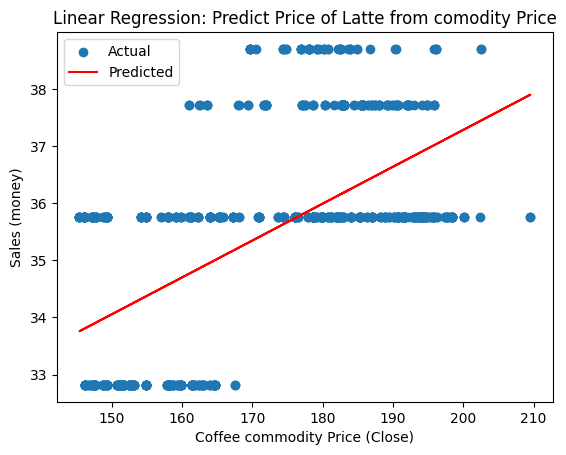

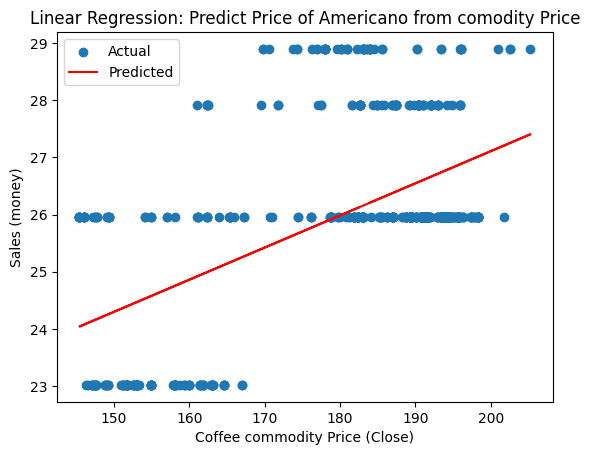

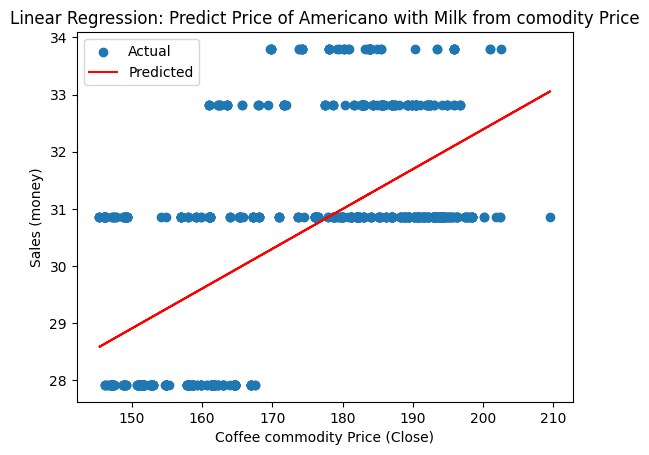

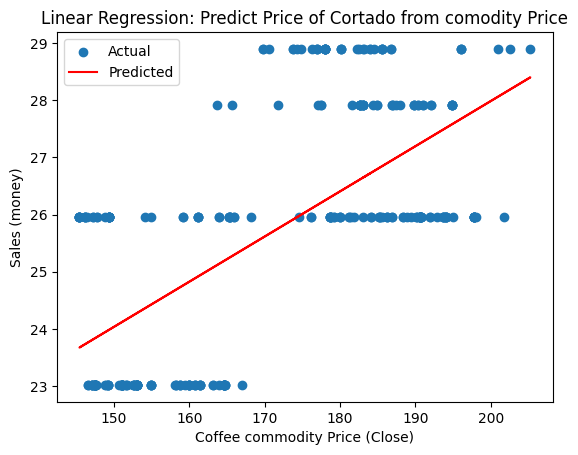

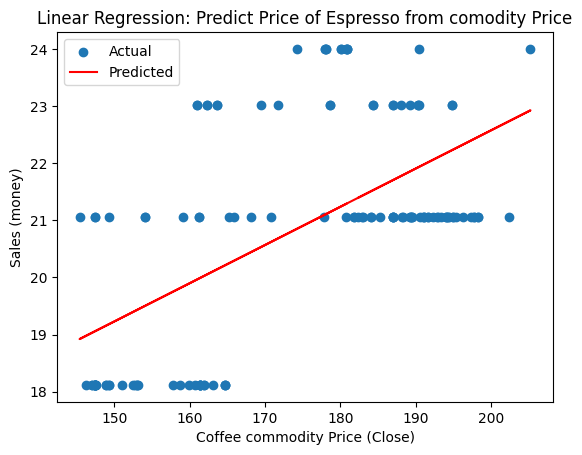

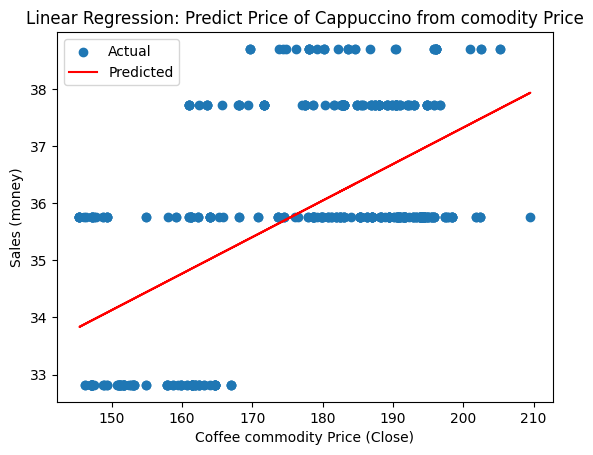

---------------------------------------------------
Latte
RMSE: 1.4677048908285801
R²: 0.3501190007174503
---------------------------------------------------
Americano
RMSE: 1.396356282688535
R²: 0.3047136360866939
---------------------------------------------------
Americano with Milk
RMSE: 1.4858262500551438
R²: 0.3771492780957211
---------------------------------------------------
Cortado
RMSE: 1.582896221056004
R²: 0.4264058672269988
---------------------------------------------------
Espresso
RMSE: 1.588899422009543
R²: 0.3470631053163187
---------------------------------------------------
Cappuccino
RMSE: 1.4816194940478817
R²: 0.3353519473718295


In [92]:
drink_list = []
rsme_list = []
r2_list = []


for drink in coffee_drinks_list:
    df_filtered = df_merged_coffee.copy()
    df_filtered = df_filtered[df_filtered["coffee_name"] == drink]

    drink_list.append(drink)

    X = df_filtered['Close']  # predictor
    y = df_filtered['money']  # response

    # Add a constant term for the intercept
    X = sm.add_constant(X)

    # Fit the regression model
    model = sm.OLS(y, X).fit()

    # Predict new values
    df_filtered['money_pred'] = model.predict(X)

    # RMSE
    rmse = np.sqrt(mean_squared_error(y, df_filtered['money_pred']))
    rsme_list.append(rmse)

    # R²
    r2 = r2_score(y, df_filtered['money_pred'])
    r2_list.append(r2)


    # Plot actual vs predicted
    plt.scatter(df_filtered['Close'], df_filtered['money'], label='Actual')
    plt.plot(df_filtered['Close'], df_filtered['money_pred'], color='red', label='Predicted')
    plt.xlabel('Coffee commodity Price (Close)')
    plt.ylabel('Sales (money)')
    plt.title(f'Linear Regression: Predict Price of {drink} from comodity Price')
    plt.legend()
    plt.show()



for i, drink in enumerate(drink_list):
    print("---------------------------------------------------")
    print(drink)
    print("RMSE:", rsme_list[i])
    print("R²:", r2_list[i])

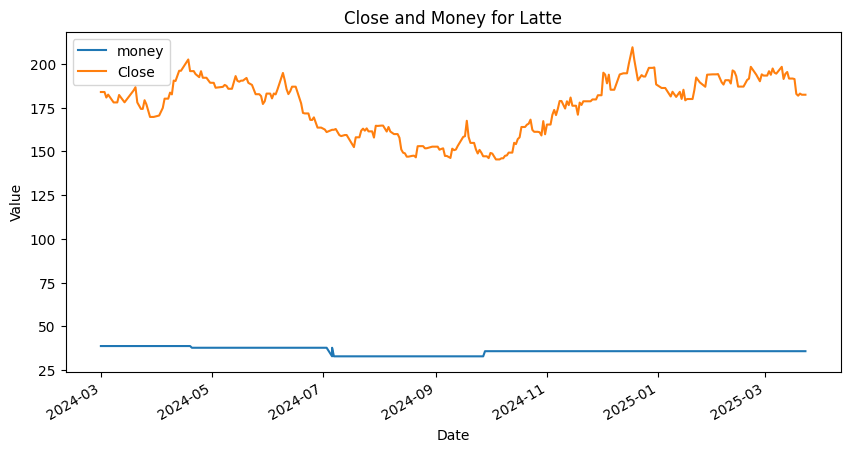

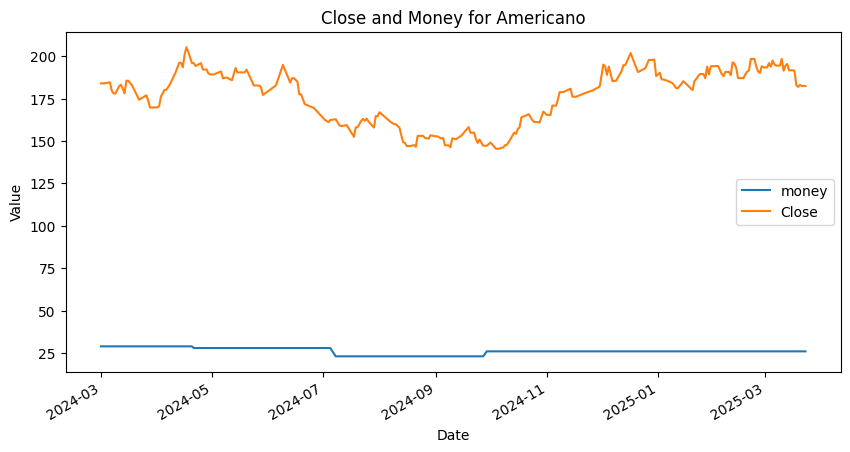

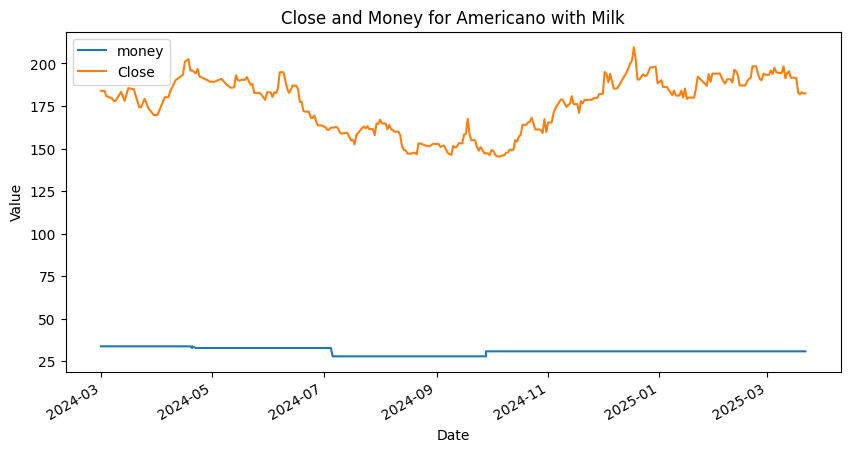

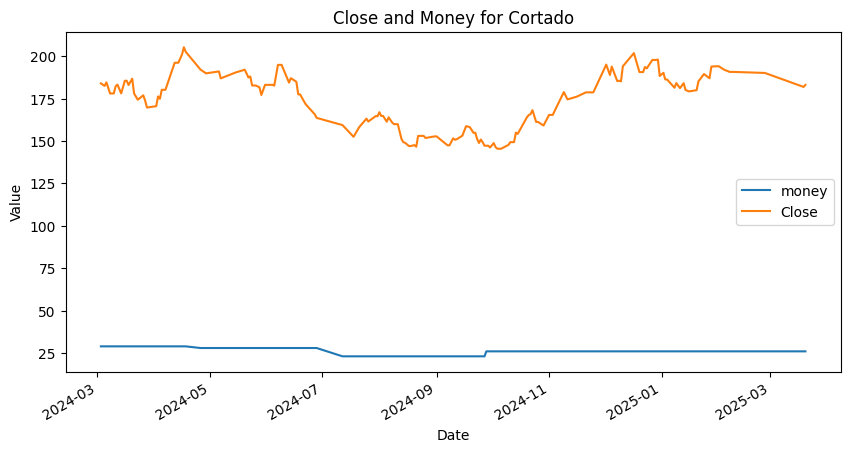

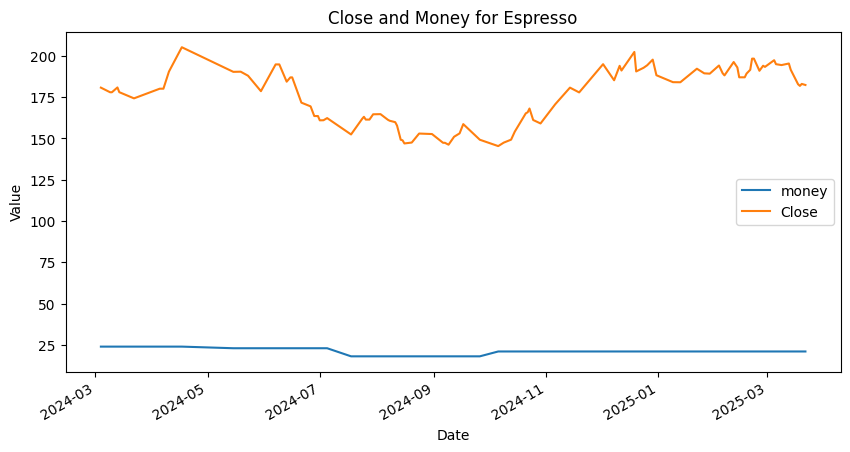

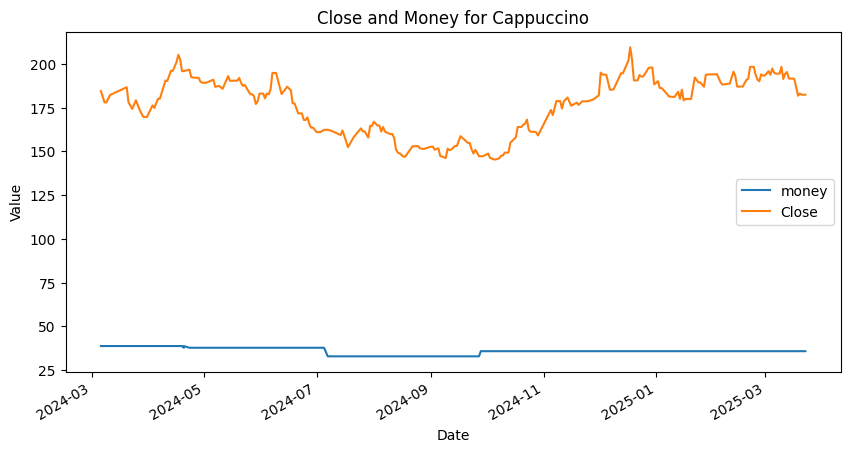

In [17]:
df_merged_coffee.head
for drink in coffee_drinks_list:
    df_filtered = df_merged_coffee.copy()
    df_filtered = df_filtered[df_filtered["coffee_name"] == drink]
    # Convert 'Date' column to datetime
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])
    df_filtered = df_filtered.set_index('Date')

     # Plot Age and Score for the two rows
    df_filtered[['money', 'Close']].plot(kind='line', figsize=(10,5))
    plt.title(f'Close and Money for {drink}')
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.show()

### Merge ticker with calander to have quotes for every day

In [42]:

df_coffee_sales_copy = df_merged_coffee.set_index("Date")
# Drop rows where index is NaT
df_ticker_data_copy = df_ticker_coffee.copy()

# Define start and end dates
start_date = '2024-01-01'
end_date = '2025-10-06'

# Create daily date range
dates = pd.date_range(start=start_date, end=end_date, freq='D')
# Convert to DataFrame
df_calendar = pd.DataFrame({'Date': dates})

df_ticker_data_copy["Date"] = pd.to_datetime(df_ticker_data_copy["Date"])
df_merged_calendar_coffee = pd.merge(df_calendar, df_ticker_data_copy, how="left", on="Date")

# order by date
df_merged_calendar_coffee = df_merged_calendar_coffee.sort_values(by="Date")

df_merged_calendar_coffee[["Close"]] = df_merged_calendar_coffee[["Close"]].ffill()
# droping first row (blank)
df_merged_calendar_coffee = df_merged_calendar_coffee.dropna(subset=["Close"])

# Set 'Date' as the index
df_merged_calendar_coffee = df_merged_calendar_coffee.set_index('Date')

print(df_merged_calendar_coffee.head(20))


                 Close
Date                  
2024-01-02  167.300003
2024-01-03  166.300003
2024-01-04  161.300003
2024-01-05  160.550003
2024-01-06  160.550003
2024-01-07  160.550003
2024-01-08  158.300003
2024-01-09  158.050003
2024-01-10  150.899994
2024-01-11  143.899994
2024-01-12  149.399994
2024-01-13  149.399994
2024-01-14  149.399994
2024-01-15  149.399994
2024-01-16  151.699997
2024-01-17  151.100006
2024-01-18  155.000000
2024-01-19  154.600006
2024-01-20  154.600006
2024-01-21  154.600006


c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertib

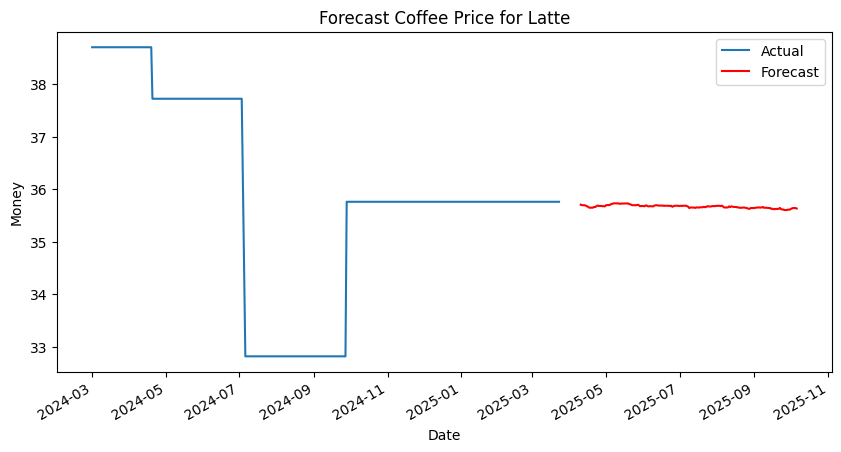

c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertib

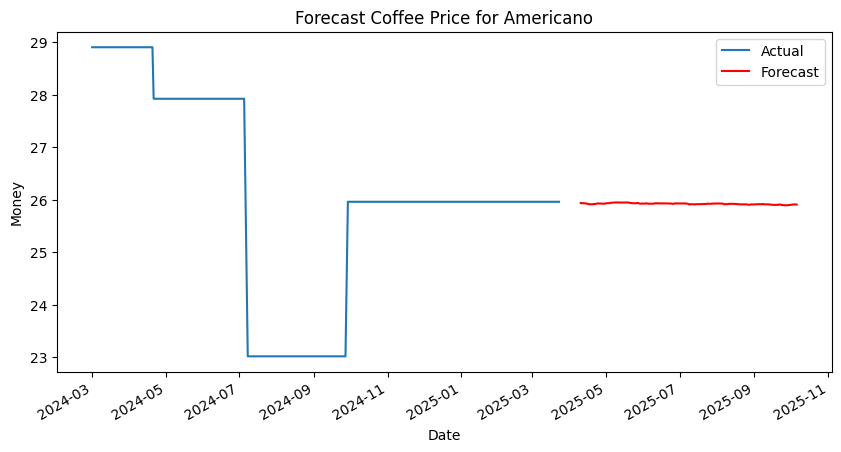

c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is availa

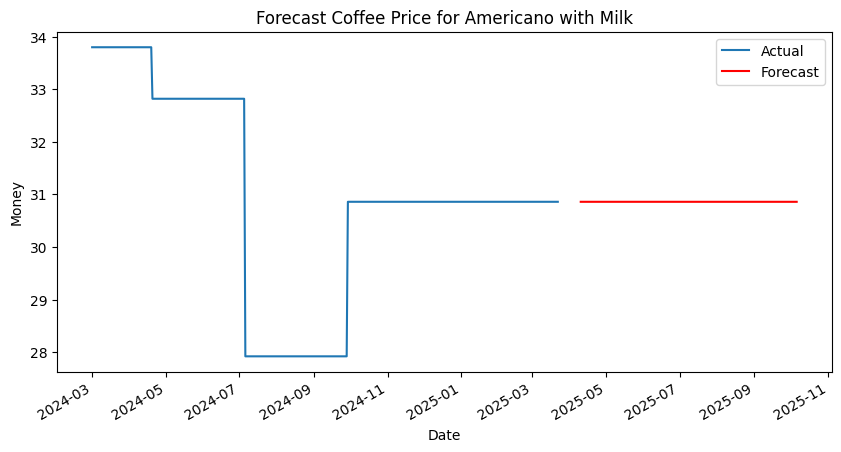

c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is availa

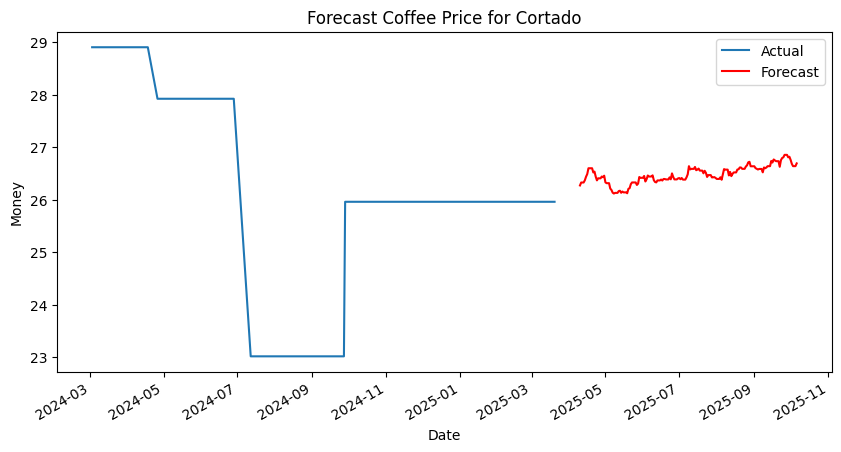

c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is availa

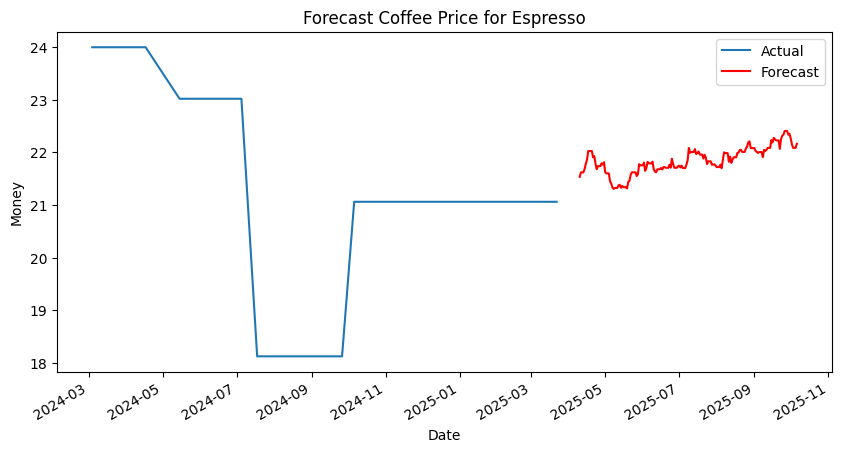

c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Friedrich\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is availa

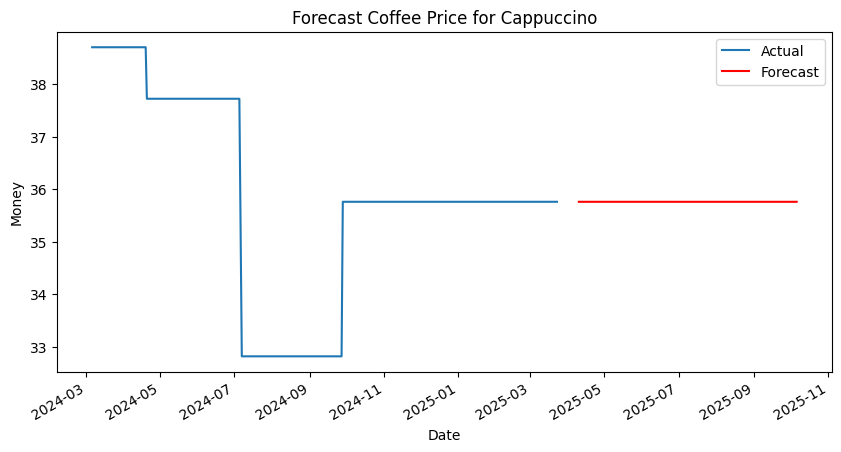

In [109]:


for drink in coffee_drinks_list:
    df_filtered = df_coffee_sales_copy[df_coffee_sales_copy["coffee_name"] == drink].copy()

    # Remove duplicate dates
    df_filtered = df_filtered.groupby(df_filtered.index).agg({
        'money': 'first',
        'coffee_name': 'first' 
    })

    # Endogenous variable: coffee price (Money)
    y = df_filtered['money']

    # Exogenous variable: stock Close
    X = df_merged_calendar_coffee[['Close']].loc[y.index]
    forecast_steps = 180
    X_test = df_merged_calendar_coffee[['Close']].iloc[-forecast_steps:]

    # # Fit ARIMAX
    model = SARIMAX(y, exog=X, order=(1,1,1))
    model_fit = model.fit(disp=False)

    # model_fit.predict(exog=X_predict)
    forecast = model_fit.get_forecast(steps=forecast_steps, exog=X_test)
    forecast_values = forecast.predicted_mean

    forecast_values.index = X_test.index

    # Plot
    y.plot(label='Actual', figsize=(10,5))
    forecast_values.plot(label='Forecast', color='red')

    plt.title(f'Forecast Coffee Price for {drink}')
    plt.xlabel('Date')
    plt.ylabel('Money')
    plt.legend()
    plt.show()

      

# Merge 

# testing for seasonality in the Comodity price

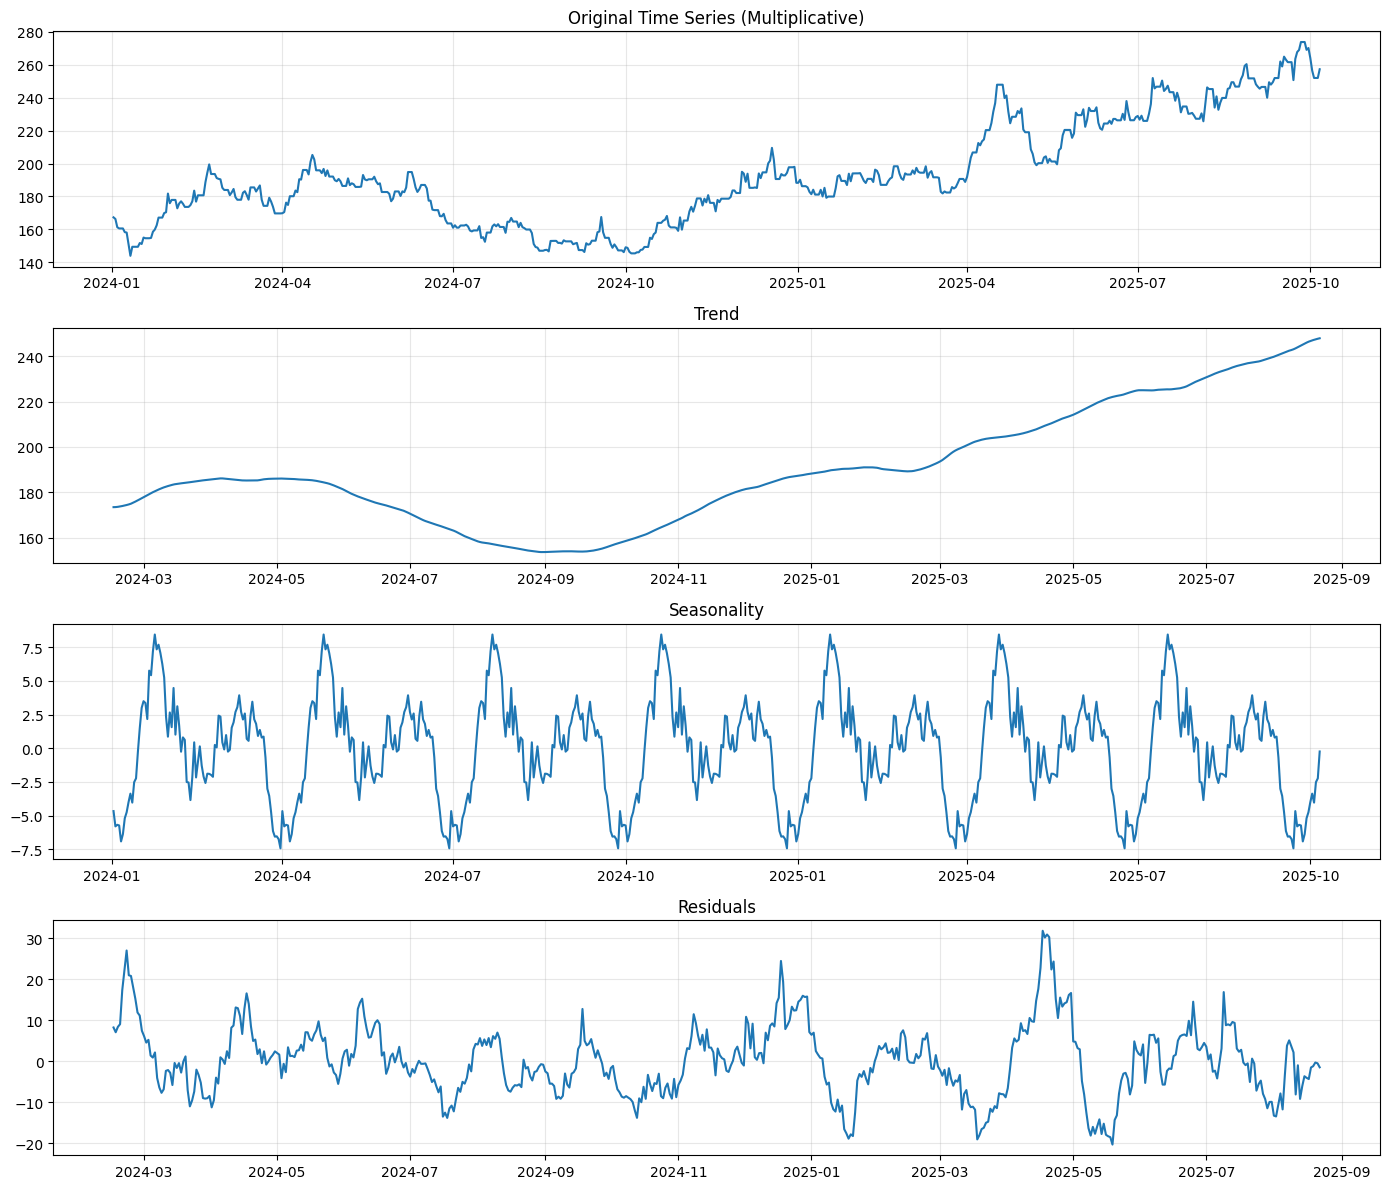

In [107]:

# Multiplicative Decomposition
decomposition_mult = seasonal_decompose(df_merged_calendar_coffee, model='additive', period=90)

plt.figure(figsize=(14, 12))
plt.subplot(411)
plt.plot(decomposition_mult.observed)
plt.title('Original Time Series (Multiplicative)')
plt.grid(True, alpha=0.3)

plt.subplot(412)
plt.plot(decomposition_mult.trend)
plt.title('Trend')
plt.grid(True, alpha=0.3)

plt.subplot(413)
plt.plot(decomposition_mult.seasonal)
plt.title('Seasonality')
plt.grid(True, alpha=0.3)

plt.subplot(414)
plt.plot(decomposition_mult.resid)
plt.title('Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Bonus: Test if there are more purchases of hot choklate when the temperature is low
csv data from:
https://open-meteo.com/en/docs/historical-weather-api?start_date=2024-01-01&latitude=34.0522&longitude=-118.2437

In [178]:
df_weather = pd.read_csv("open-meteo-34.06N118.24W91m.csv")
df_weather = df_weather.rename(columns={"time":"Date"})
df_weather['Date'] = pd.to_datetime(df_weather['Date']).dt.date

df_weather_grouped = df_weather.groupby("Date").max("temperature_2m (°C)")
# Convert Series to DataFrame and rename column
df_weather_grouped = df_weather_grouped.reset_index()
df_weather_grouped['Date'] = pd.to_datetime(df_weather_grouped['Date'])
df_weather_grouped.head()

# df_weather.head()

,Date,temperature_2m (°C)
0,2024-01-01,17.0
1,2024-01-02,16.9
2,2024-01-03,16.5
3,2024-01-04,14.9
4,2024-01-05,15.7


### join on sales Data

In [192]:
df_cocoa.dtypes
df_cocoa_copy = df_cocoa.copy()

# Convert Date column to datetime
df_cocoa_copy['Date'] = pd.to_datetime(df_cocoa_copy['Date'])
# Filter for Hot Chocolate
df_hot_choclate = df_cocoa_copy[df_cocoa_copy["coffee_name"] == "Hot Chocolate"]
# Group by Date and count
df_hot_chocolate_grouped = df_hot_choclate.groupby("Date")["coffee_name"].count()
# Convert Series to DataFrame and rename column
df_hot_chocolate_grouped = df_hot_chocolate_grouped.reset_index()
df_hot_chocolate_grouped = df_hot_chocolate_grouped.rename(columns={"coffee_name": "hot_chocolate_count"})
df_hot_chocolate_grouped['Date'] = pd.to_datetime(df_hot_chocolate_grouped['Date'])

# merge weather and hot choclate purchases
df_cocoa_and_weather = pd.merge( df_weather_grouped, df_hot_chocolate_grouped, how="right", on="Date")


df_cocoa_and_weather.head()

,Date,temperature_2m (°C),hot_chocolate_count
0,2024-03-01,16.1,3
1,2024-03-03,16.3,2
2,2024-03-05,18.2,4
3,2024-03-07,18.1,1
4,2024-03-09,20.4,2


In [193]:
# control if there duplicates were created
print(len(df_cocoa_copy))
print(len(df_cocoa_and_weather))

515
157


In [201]:
print("########## Hot Chocolate #################")

# Test linear  correlation of COFFEE
print("--- Test linear correlation of Hot Chocolat and weather --- ")
# assuming df_merged has 'money' (sales) and 'Close' (cocoa price)
r, p_value = pearsonr(df_cocoa_and_weather["hot_chocolate_count"], df_cocoa_and_weather["temperature_2m (°C)"])

print("Pearson correlation coefficient:", r)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("Refuse the null hypothesis H₀: -> Changes in the weather affect the purchasing frequency of Hot choclate.")
else:
    print("Cannot refuse the null hypthesis: -> There is NO relationship between the frequency of hot chocolate purchases and the Weather")

########## Hot Chocolate #################
--- Test linear correlation of Hot Chocolat and weather --- 
Pearson correlation coefficient: 0.03487360421772213
p-value: 0.6645752207053449
Cannot refuse the null hypthesis: -> There is NO relationship between the frequency of hot chocolate purchases and the Weather


In [195]:
print("--- Test monotonic correlation of Hot Chocolate  --- ")

rho, p_value = spearmanr(df_cocoa_and_weather["hot_chocolate_count"], df_cocoa_and_weather["temperature_2m (°C)"])

print("Spearman correlation:", rho)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("Refuse the null hypothesis H₀: -> Changes in the weather affect the purchasing frequency of Hot choclate.")
else:
    print("Cannot refuse the null hypthesis: -> There is NO relationship between the frequency of hot chocolate purchases and the Weather")

--- Test monotonic correlation of Hot Chocolate  --- 
Spearman correlation: 0.013599556486906519
p-value: 0.8657588309997017
Cannot refuse the null hypthesis: -> There is NO relationship between the frequency of hot chocolate purchases and the Weather


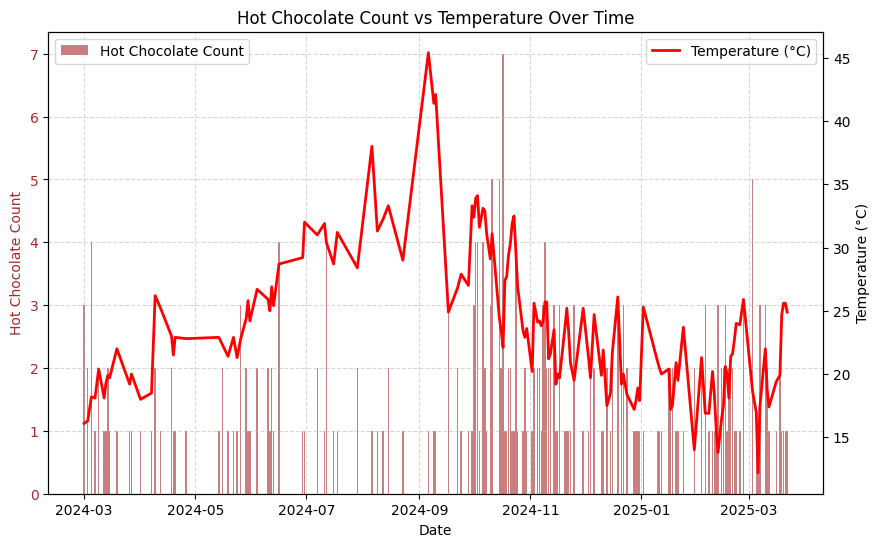

In [203]:

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for hot chocolate count
ax1.bar(df_cocoa_and_weather['Date'], df_cocoa_and_weather['hot_chocolate_count'], color='brown', alpha=0.6, label='Hot Chocolate Count')
ax1.set_ylabel('Hot Chocolate Count', color='brown')
ax1.tick_params(axis='y', labelcolor='brown')

# Line chart for temperature (no dots)
ax2 = ax1.twinx()
ax2.plot(df_cocoa_and_weather['Date'], df_cocoa_and_weather['temperature_2m (°C)'], color='red', linewidth=2, label='Temperature (°C)')
ax2.set_ylabel('Temperature (°C)')
ax2.tick_params(axis='y')

# Title, labels, and grid
plt.title("Hot Chocolate Count vs Temperature Over Time")
ax1.set_xlabel("Date")
ax1.grid(True, linestyle='--', alpha=0.5)

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

### find out which drinks are most populate in each month in order to fill up stock

max date: 2025-03-23 00:00:00
min date: 2024-03-01 00:00:00


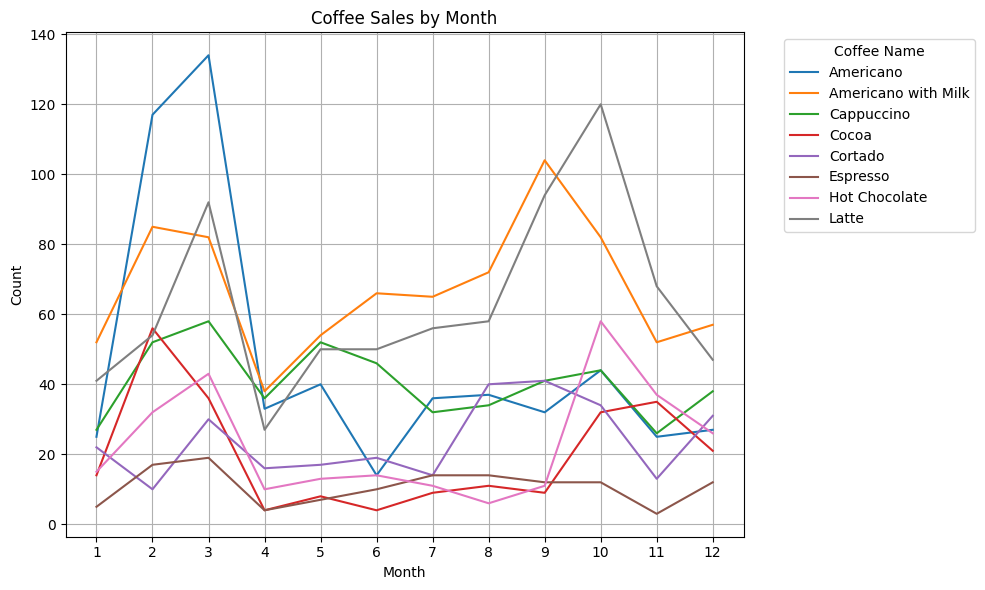

In [213]:
df_cocoa.dtypes
df_sales_copy = sales.copy()

# Convert Date column to datetime
df_sales_copy['Date'] = pd.to_datetime(df_sales_copy['Date'])
df_sales_copy["month_nr"] = df_sales_copy['Date'].dt.month
print("max date:" , df_sales_copy['Date'].max())
print("min date:" , df_sales_copy['Date'].min())
# Filter for Hot Chocolate
# df_hot_choclate = df_cocoa_copy[df_cocoa_copy["coffee_name"] == "Hot Chocolate"]
# Group by Date and count
df_sales_grouped = df_sales_copy.groupby(["month_nr", "coffee_name"])["coffee_name"].count()

df_sales_grouped = df_sales_grouped.reset_index(name='count')

# Plot each month
months = df_sales_grouped['month_nr'].unique()

# Pivot the DataFrame
df_pivot = df_sales_grouped.pivot(index='month_nr', columns='coffee_name', values='count')
# Plot line chart

# Plot line chart without markers
plt.figure(figsize=(10,6))
for coffee in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[coffee], label=coffee)  # removed marker='o'

plt.title('Coffee Sales by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(df_pivot.index)  # ensures all months are shown
plt.legend(title='Coffee Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [300]:
df_sales_copy = sales.copy()
alpha = 0.05

# Convert Date column to datetime
df_sales_copy['Date'] = pd.to_datetime(df_sales_copy['Date'])

df_hot_chocolate_or_latte = df_sales_copy[
    (df_sales_copy["coffee_name"] == "Hot Chocolate") |
    (df_sales_copy["coffee_name"] == "Latte")
]

df_summary = (
    df_hot_chocolate_or_latte
    .groupby(["Monthsort", "coffee_name"])
    .size()
    .reset_index(name="count")
    .pivot(index="Monthsort", columns="coffee_name", values="count")
    .fillna(0)
    .reset_index()
)

_, p_value = st.ttest_rel(df_summary["Latte"], df_summary["Hot Chocolate"], alternative='two-sided')
print("p_value", p_value)

if p_value < alpha:
    print("There is a statistically significant difference between monthly Latte and Hot Chocolate sales, suggesting one sells more on average.")
else:
    print("There is no statistically significant difference in average monthly sales between Latte and Hot Chocolate")



p_value 1.768116104684332e-05
There is a statistically significant difference between monthly Latte and Hot Chocolate sales, suggesting one sells more on average.


In [ ]:
df_sales_copy = sales.copy()
alpha = 0.05

# Filter only Hot Chocolate sales
df_hot_chocolate = df_sales_copy[df_sales_copy["coffee_name"] == "Hot Chocolate"]


df_daily = df_hot_chocolate.groupby(["Monthsort", "Date"]).size().reset_index(name="count")

# Filter for September and October
df_09 = df_daily[df_daily["Monthsort"] == 9]["count"]
df_10 = df_daily[df_daily["Monthsort"] == 10]["count"]

# Run independent t-test
t_stat, p_value = st.ttest_ind(df_09, df_10, alternative='two-sided', equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_value)

if p_value < alpha:
    print("There’s a statistically significant difference in mean sales between September and October — the difference is unlikely due to random chance.")
else:
    print("There’s no statistically significant difference — the variation could just be random.")

t-statistic: -2.5957674965050943
p-value: 0.015057256026750713
There’s a statistically significant difference in mean sales between September and October — the difference is unlikely due to random chance.
